In [1]:
# !pip install -U finance-datareader

In [2]:
# 폰트 설치
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [3]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import FinanceDataReader as fdr

In [4]:
def call_dataset(ticker = '005930', stt = '2015-01-01', end = '2021-04-26', history_points = 50):
    data = fdr.DataReader(ticker, stt, end)
    data = data.iloc[:,0:-1]
    print('data: ', data.shape)
    data = data.values # 값만 갖고온다
    data_normalizer = preprocessing.MinMaxScaler() # 데이터를 0~1 범위로 점철되게 하는 함수 call
    data_normalized = data_normalizer.fit_transform(data) # 데이터를 0~1 범위로 점철되게 함수 수행
    print('data_normalized: ', data_normalized.shape)
     # using the last {history_points} open close high low volume data points, predict the next open value
    ohlcv_histories_normalized = np.array([data_normalized[i:i + history_points].copy() for i in range(len(data_normalized) - history_points)]) # ohlcv를 가지고 오되, 관찰일수 만큼 누적해서 쌓는다. (열방향으로)
    print('ohlcv_histories_normalized: ', ohlcv_histories_normalized.shape)

    next_day_open_values_normalized = np.array([data_normalized[:, 0][i + history_points].copy() for i in range(len(data_normalized) - history_points)])
    next_day_open_values_normalized = np.expand_dims(next_day_open_values_normalized, -1) # 1XN 벡터 -> NX1 벡터로

    next_day_open_values = np.array([data[:, 0][i + history_points].copy() for i in range(len(data) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values, -1) # 1XN 벡터 -> NX1 벡터로

    y_normalizer = preprocessing.MinMaxScaler()
    y_normalizer.fit(next_day_open_values)

    def calc_ema(values, time_period):
        # https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
        sma = np.mean(values[:, 3])
        ema_values = [sma]
        k = 2 / (1 + time_period)
        for i in range(len(his) - time_period, len(his)):
            close = his[i][3]
            ema_values.append(close * k + ema_values[-1] * (1 - k))
        return ema_values[-1]

    technical_indicators = []
    for his in ohlcv_histories_normalized:
        # note since we are using his[3] we are taking the SMA of the closing price
        # print('his: ', his)
        # print('his[:, 3]: ', his[:, 3])
        sma = np.mean(his[:, 3]) # 각 데이터포인트별 Close Price 평균
        macd = calc_ema(his, 12) - calc_ema(his, 26) # 12일 EMA - 26일 EMA
        technical_indicators.append(np.array([sma]))
        # technical_indicators.append(np.array([sma,macd,]))

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalized = tech_ind_scaler.fit_transform(technical_indicators)

    technical_indicators = np.array(technical_indicators)

    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalized = tech_ind_scaler.fit_transform(technical_indicators)

    assert ohlcv_histories_normalized.shape[0] == next_day_open_values_normalized.shape[0] == technical_indicators_normalized.shape[0]

    print('ohlcv_histories_normalized.shape[0]: ', ohlcv_histories_normalized.shape[0])

    return ohlcv_histories_normalized, technical_indicators_normalized, next_day_open_values_normalized, next_day_open_values, y_normalizer

### NAVER

In [5]:
history_points = 50
ticker = '035420' # NAVER

import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers

np.random.seed(3)
# from tensorflow import set_random_seed
import tensorflow
print(tensorflow.__version__)
tensorflow.random.set_seed(33)
# from util import csv_to_dataset, history_points

# dataset

ohlcv_histories, _, next_day_open_values, unscaled_y, y_normaliser = call_dataset(ticker=ticker)

train_ratio = 0.7
n = int(ohlcv_histories.shape[0] * train_ratio)

ohlcv_train = ohlcv_histories[-n:-1]
y_train = next_day_open_values[-n:-1]

ohlcv_test = ohlcv_histories[:ohlcv_histories.shape[0]-n]
y_test = next_day_open_values[:ohlcv_histories.shape[0]-n]

unscaled_y_test = unscaled_y[:ohlcv_histories.shape[0]-n]

print('ohlcv_train.shape: ', ohlcv_train.shape)
print('ohlcv_test.shape: ',ohlcv_test.shape)

2.4.1
data:  (1553, 5)
data_normalized:  (1553, 5)
ohlcv_histories_normalized:  (1503, 50, 5)
ohlcv_histories_normalized.shape[0]:  1503
ohlcv_train.shape:  (1051, 50, 5)
ohlcv_test.shape:  (451, 50, 5)


In [6]:
ohlcv_train 

array([[[0.42793043, 0.42010244, 0.42186183, 0.24820538, 0.04235125],
        [0.42245714, 0.41521707, 0.41729726, 0.23468427, 0.01609307],
        [0.41101118, 0.40349268, 0.41172003, 0.22567019, 0.0128843 ],
        ...,
        [0.39359752, 0.39128293, 0.39853772, 0.21729906, 0.00947664],
        [0.3936    , 0.39030976, 0.39397568, 0.2044241 , 0.01445711],
        [0.39160994, 0.38737805, 0.39499087, 0.21279523, 0.0089305 ]],

       [[0.42245714, 0.41521707, 0.41729726, 0.23468427, 0.01609307],
        [0.41101118, 0.40349268, 0.41172003, 0.22567019, 0.0128843 ],
        [0.40205963, 0.39568293, 0.39803392, 0.21086318, 0.01931843],
        ...,
        [0.3936    , 0.39030976, 0.39397568, 0.2044241 , 0.01445711],
        [0.39160994, 0.38737805, 0.39499087, 0.21279523, 0.0089305 ],
        [0.39111304, 0.39177317, 0.39854025, 0.21537022, 0.00918877]],

       [[0.41101118, 0.40349268, 0.41172003, 0.22567019, 0.0128843 ],
        [0.40205963, 0.39568293, 0.39803392, 0.21086318, 0.0

In [7]:
# model architecture
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=200, shuffle=True, validation_split=0.1)
# evaluation

y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

from datetime import datetime
model.save(f'basic_model.h5')

Epoch 1/200
30/30 [==============================] - 18s 32ms/step - loss: 0.1734 - val_loss: 0.0227
Epoch 2/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0642
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0215
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0029 - val_loss: 0.0064
Epoch 5/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 6/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 7/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 8/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 9/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0038
Epoch 10/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 1

In [8]:
# 시각화 모듈 임포트
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import font_manager, rc

# colab 내 그래프를 바로 그리기 위한 설정
%matplotlib inline

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False

# font 적용
plt.rc('font', family = 'NanumBarunGothic')

# ggplot 으로 그래프 스타일 설정
plt.style.use('ggplot')

# 레티나 설정 : 글자가 흐릿하게 보이는 현상 방지
%config InlineBackend.figure_format = 'retina'

# warning 방지
import warnings  
warnings.filterwarnings(action = 'ignore')

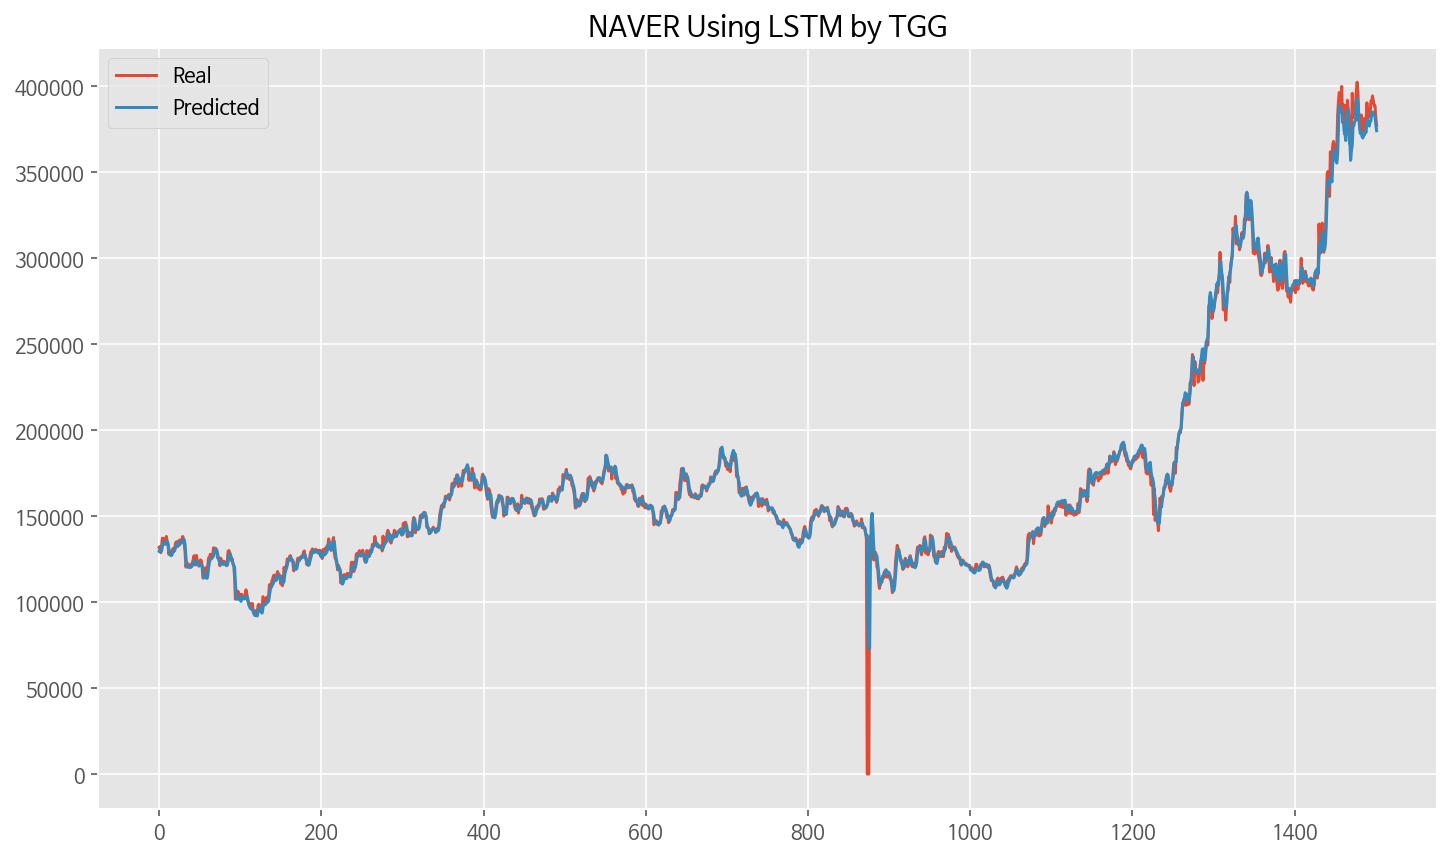

In [9]:
plt.gcf().set_size_inches(12, 7, forward=True)

start = 0
end = -1

# real = plt.plot(unscaled_y_test[start:end], label='real') 
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.title('NAVER Using LSTM by TGG')
plt.show();

In [10]:
col_name = ['real', 'pred']
real, pred = pd.DataFrame(unscaled_y[start:end]), pd.DataFrame(y_predicted[start:end])
foo = pd.concat([real, pred], axis = 1)
foo.columns = col_name

In [11]:
foo

,real,pred
0,131785,129539.804688
1,132387,130597.609375
2,128781,130014.585938
3,132187,129657.742188
4,137192,132407.468750
...,...,...
1497,391500,384773.687500
1498,389000,383266.218750
1499,389000,382413.937500
1500,382000,377952.968750


In [12]:
foo.corr()

,real,pred
real,1.000000,0.995822
pred,0.995822,1.000000


In [13]:
foo['real+1'] = foo['real'].shift(periods = 1)
foo[['real+1', 'pred']].corr()

,real+1,pred
real+1,1.000000,0.997741
pred,0.997741,1.000000


### KAKAO

In [14]:
history_points = 50
ticker = '035720' # KAKAO

import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers

np.random.seed(3)
# from tensorflow import set_random_seed
import tensorflow
print(tensorflow.__version__)
tensorflow.random.set_seed(33)
# from util import csv_to_dataset, history_points

# dataset

ohlcv_histories, _, next_day_open_values, unscaled_y, y_normaliser = call_dataset(ticker=ticker)

train_ratio = 0.7
n = int(ohlcv_histories.shape[0] * train_ratio)

ohlcv_train = ohlcv_histories[-n:-1]
y_train = next_day_open_values[-n:-1]

ohlcv_test = ohlcv_histories[:ohlcv_histories.shape[0]-n]
y_test = next_day_open_values[:ohlcv_histories.shape[0]-n]

unscaled_y_test = unscaled_y[:ohlcv_histories.shape[0]-n]

print('ohlcv_train.shape: ', ohlcv_train.shape)
print('ohlcv_test.shape: ',ohlcv_test.shape)

2.4.1
data:  (1553, 5)
data_normalized:  (1553, 5)
ohlcv_histories_normalized:  (1503, 50, 5)
ohlcv_histories_normalized.shape[0]:  1503
ohlcv_train.shape:  (1051, 50, 5)
ohlcv_test.shape:  (451, 50, 5)


In [15]:
# model architecture
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=200, shuffle=True, validation_split=0.1)
# evaluation

y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

from datetime import datetime
model.save(f'basic_model.h5')

Epoch 1/200
30/30 [==============================] - 2s 22ms/step - loss: 0.0801 - val_loss: 0.0606
Epoch 2/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0391
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0238
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0250
Epoch 5/200
30/30 [==============================] - 0s 6ms/step - loss: 8.6463e-04 - val_loss: 0.0224
Epoch 6/200
30/30 [==============================] - 0s 6ms/step - loss: 6.9523e-04 - val_loss: 0.0225
Epoch 7/200
30/30 [==============================] - 0s 6ms/step - loss: 7.7511e-04 - val_loss: 0.0219
Epoch 8/200
30/30 [==============================] - 0s 6ms/step - loss: 5.8450e-04 - val_loss: 0.0221
Epoch 9/200
30/30 [==============================] - 0s 6ms/step - loss: 6.9275e-04 - val_loss: 0.0238
Epoch 10/200
30/30 [==============================] - 0s 6ms/step - loss: 5.5146e-04 - v

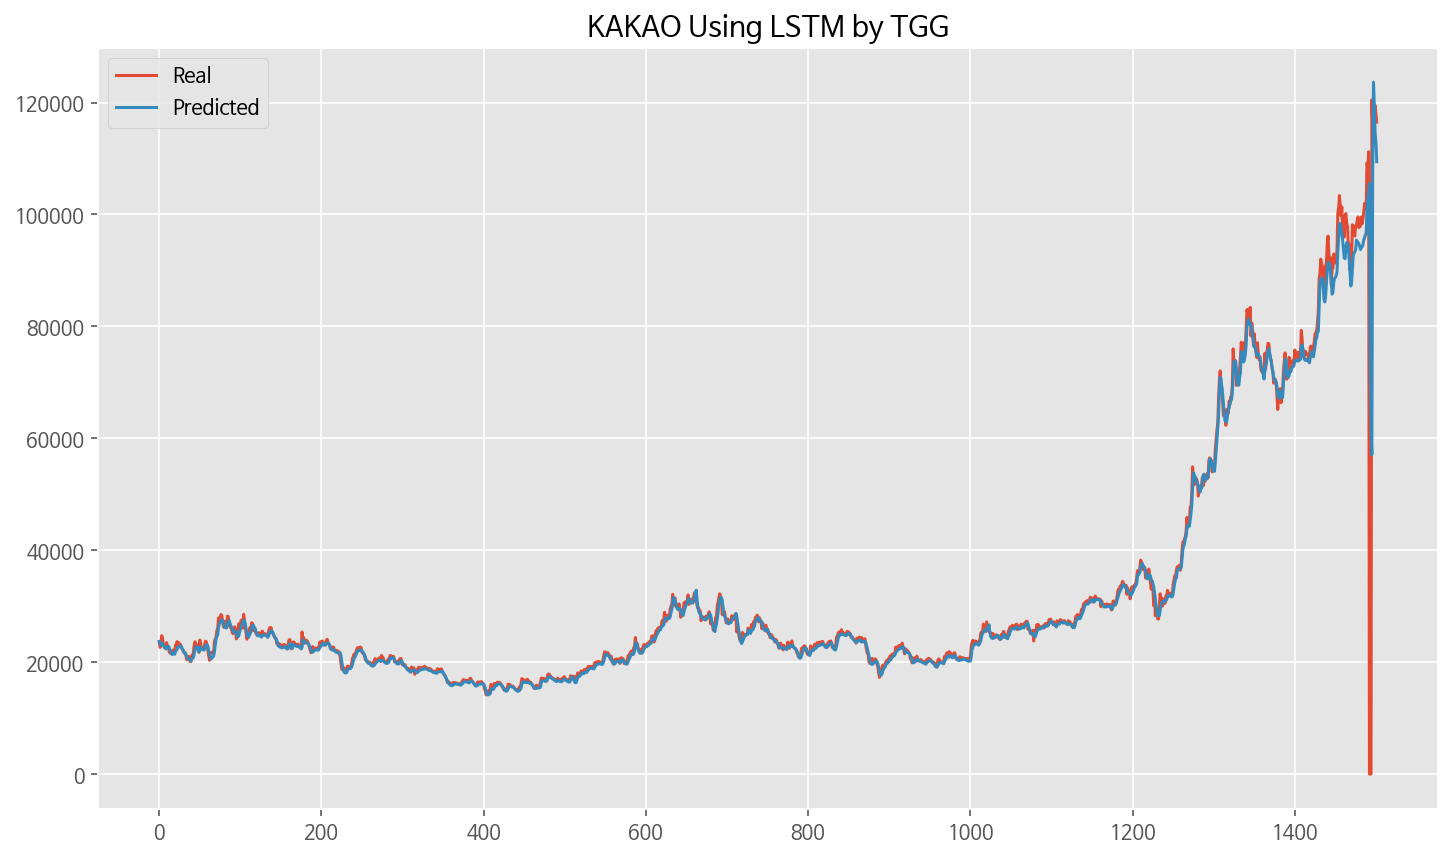

In [16]:
plt.gcf().set_size_inches(12, 7, forward=True)

start = 0
end = -1

# real = plt.plot(unscaled_y_test[start:end], label='real') 
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.title('KAKAO Using LSTM by TGG')
plt.show();

In [17]:
col_name = ['real', 'pred']
real, pred = pd.DataFrame(unscaled_y[start:end]), pd.DataFrame(y_predicted[start:end])
foo = pd.concat([real, pred], axis = 1)
foo.columns = col_name

In [18]:
foo

,real,pred
0,23603,23711.509766
1,22620,23354.291016
2,22941,22957.011719
3,24727,23119.367188
4,24285,23382.039062
...,...,...
1497,119999,123641.781250
1498,119000,119645.406250
1499,119500,114593.921875
1500,118000,112845.023438


In [19]:
foo.corr()

,real,pred
real,1.000000,0.980094
pred,0.980094,1.000000


In [20]:
foo['real+1'] = foo['real'].shift(periods = 1)
foo[['real+1', 'pred']].corr()

,real+1,pred
real+1,1.000000,0.989389
pred,0.989389,1.000000


In [21]:
history_points = 50
ticker = '005930' # 삼성전자

import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers

np.random.seed(3)
# from tensorflow import set_random_seed
import tensorflow
print(tensorflow.__version__)
tensorflow.random.set_seed(33)
# from util import csv_to_dataset, history_points

# dataset

ohlcv_histories, _, next_day_open_values, unscaled_y, y_normaliser = call_dataset(ticker=ticker)

train_ratio = 0.7
n = int(ohlcv_histories.shape[0] * train_ratio)

ohlcv_train = ohlcv_histories[-n:-1]
y_train = next_day_open_values[-n:-1]

ohlcv_test = ohlcv_histories[:ohlcv_histories.shape[0]-n]
y_test = next_day_open_values[:ohlcv_histories.shape[0]-n]

unscaled_y_test = unscaled_y[:ohlcv_histories.shape[0]-n]

print('ohlcv_train.shape: ', ohlcv_train.shape)
print('ohlcv_test.shape: ',ohlcv_test.shape)

2.4.1
data:  (1553, 5)
data_normalized:  (1553, 5)
ohlcv_histories_normalized:  (1503, 50, 5)
ohlcv_histories_normalized.shape[0]:  1503
ohlcv_train.shape:  (1051, 50, 5)
ohlcv_test.shape:  (451, 50, 5)


In [22]:
# model architecture
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=200, shuffle=True, validation_split=0.1)
# evaluation

y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

from datetime import datetime
model.save(f'basic_model.h5')

Epoch 1/200
30/30 [==============================] - 3s 22ms/step - loss: 0.2579 - val_loss: 0.0114
Epoch 2/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0631
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0444
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0490
Epoch 5/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0036 - val_loss: 0.0423
Epoch 6/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0391
Epoch 7/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0382
Epoch 8/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0331
Epoch 9/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0308
Epoch 10/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0263
Epoch 11

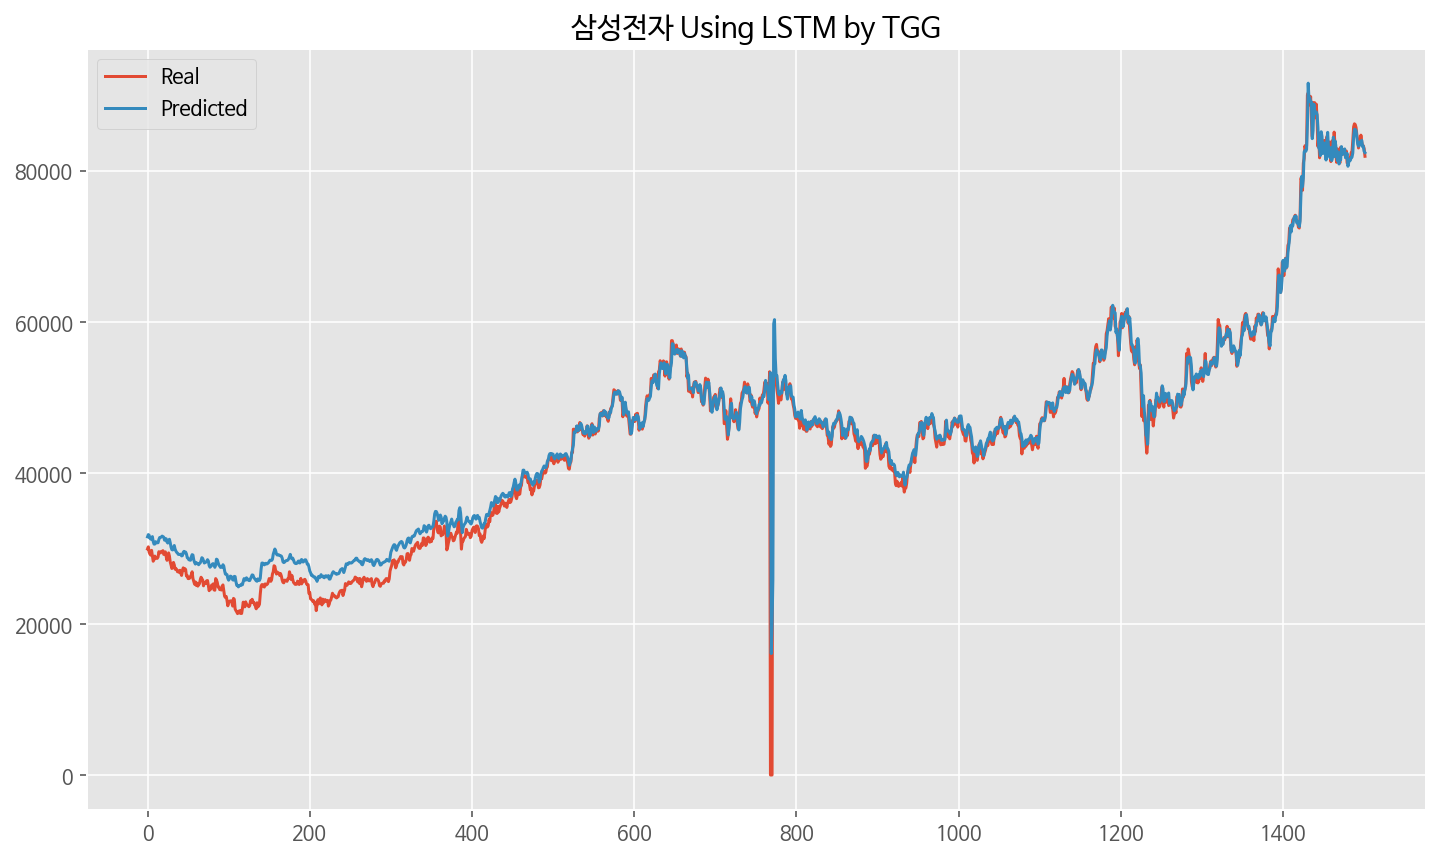

In [23]:
plt.gcf().set_size_inches(12, 7, forward=True)

start = 0
end = -1

# real = plt.plot(unscaled_y_test[start:end], label='real') 
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.title('삼성전자 Using LSTM by TGG')
plt.show();

In [24]:
col_name = ['real', 'pred']
real, pred = pd.DataFrame(unscaled_y[start:end]), pd.DataFrame(y_predicted[start:end])
foo = pd.concat([real, pred], axis = 1)
foo.columns = col_name

In [25]:
foo

,real,pred
0,29920,31528.632812
1,30200,31824.515625
2,29500,31737.400391
3,29240,31341.248047
4,29099,31216.621094
...,...,...
1497,83800,84007.468750
1498,83300,83174.812500
1499,83300,83236.101562
1500,82900,82543.695312


In [26]:
foo.corr()

,real,pred
real,1.000000,0.991776
pred,0.991776,1.000000


In [27]:
foo['real+1'] = foo['real'].shift(periods = 1)
foo[['real+1', 'pred']].corr()

,real+1,pred
real+1,1.000000,0.997083
pred,0.997083,1.000000


In [28]:
history_points = 50
ticker = '036570' # 엔씨소프트

import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers

np.random.seed(3)
# from tensorflow import set_random_seed
import tensorflow
print(tensorflow.__version__)
tensorflow.random.set_seed(33)
# from util import csv_to_dataset, history_points

# dataset

ohlcv_histories, _, next_day_open_values, unscaled_y, y_normaliser = call_dataset(ticker=ticker)

train_ratio = 0.7
n = int(ohlcv_histories.shape[0] * train_ratio)

ohlcv_train = ohlcv_histories[-n:-1]
y_train = next_day_open_values[-n:-1]

ohlcv_test = ohlcv_histories[:ohlcv_histories.shape[0]-n]
y_test = next_day_open_values[:ohlcv_histories.shape[0]-n]

unscaled_y_test = unscaled_y[:ohlcv_histories.shape[0]-n]

print('ohlcv_train.shape: ', ohlcv_train.shape)
print('ohlcv_test.shape: ',ohlcv_test.shape)

2.4.1
data:  (1553, 5)
data_normalized:  (1553, 5)
ohlcv_histories_normalized:  (1503, 50, 5)
ohlcv_histories_normalized.shape[0]:  1503
ohlcv_train.shape:  (1051, 50, 5)
ohlcv_test.shape:  (451, 50, 5)


In [29]:
# model architecture
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=200, shuffle=True, validation_split=0.1)
# evaluation

y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

from datetime import datetime
model.save(f'basic_model.h5')

Epoch 1/200
30/30 [==============================] - 2s 23ms/step - loss: 0.1692 - val_loss: 0.0367
Epoch 2/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0166 - val_loss: 0.0594
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.0019
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 5/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 6/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 7/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 8/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 9/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 10/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 9.2993e-04
Epoc

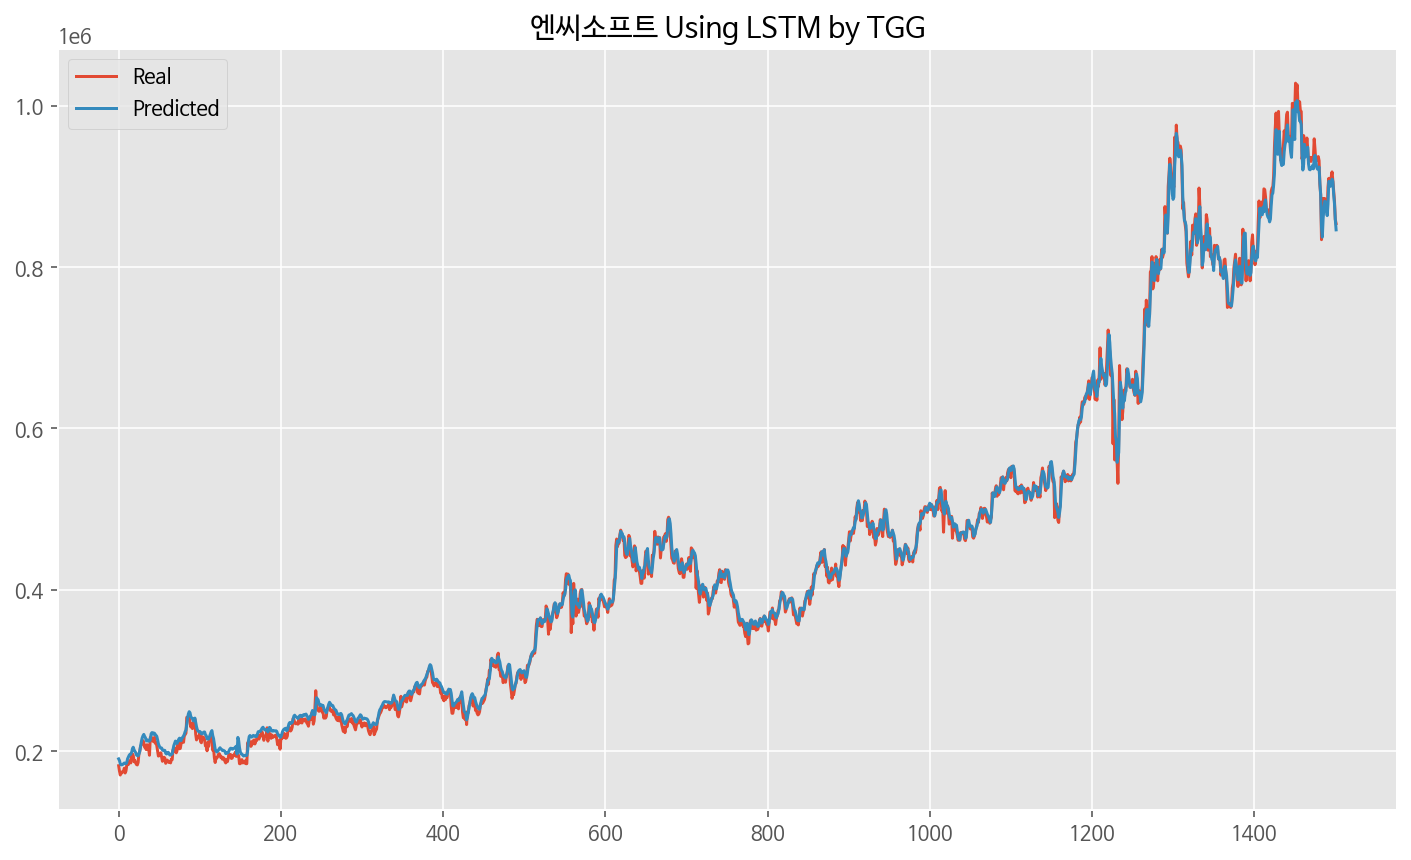

In [30]:
plt.gcf().set_size_inches(12, 7, forward=True)

start = 0
end = -1

# real = plt.plot(unscaled_y_test[start:end], label='real') 
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.title('엔씨소프트 Using LSTM by TGG')
plt.show();

In [31]:
col_name = ['real', 'pred']
real, pred = pd.DataFrame(unscaled_y[start:end]), pd.DataFrame(y_predicted[start:end])
foo = pd.concat([real, pred], axis = 1)
foo.columns = col_name

In [32]:
foo

,real,pred
0,182000,190501.703125
1,175500,188411.234375
2,170500,184261.468750
3,173500,183091.750000
4,173000,183130.484375
...,...,...
1497,907000,906263.062500
1498,894000,890106.125000
1499,882000,878574.812500
1500,859000,859158.062500


In [33]:
foo.corr()

,real,pred
real,1.000000,0.999328
pred,0.999328,1.000000


In [34]:
foo['real+1'] = foo['real'].shift(periods = 1)
foo[['real+1', 'pred']].corr()

,real+1,pred
real+1,1.000000,0.999546
pred,0.999546,1.000000


In [35]:
history_points = 50
ticker = '000660' # SK하이닉스

import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers

np.random.seed(3)
# from tensorflow import set_random_seed
import tensorflow
print(tensorflow.__version__)
tensorflow.random.set_seed(33)
# from util import csv_to_dataset, history_points

# dataset

ohlcv_histories, _, next_day_open_values, unscaled_y, y_normaliser = call_dataset(ticker=ticker)

train_ratio = 0.7
n = int(ohlcv_histories.shape[0] * train_ratio)

ohlcv_train = ohlcv_histories[-n:-1]
y_train = next_day_open_values[-n:-1]

ohlcv_test = ohlcv_histories[:ohlcv_histories.shape[0]-n]
y_test = next_day_open_values[:ohlcv_histories.shape[0]-n]

unscaled_y_test = unscaled_y[:ohlcv_histories.shape[0]-n]

print('ohlcv_train.shape: ', ohlcv_train.shape)
print('ohlcv_test.shape: ',ohlcv_test.shape)

2.4.1
data:  (1553, 5)
data_normalized:  (1553, 5)
ohlcv_histories_normalized:  (1503, 50, 5)
ohlcv_histories_normalized.shape[0]:  1503
ohlcv_train.shape:  (1051, 50, 5)
ohlcv_test.shape:  (451, 50, 5)


In [36]:
# model architecture
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=200, shuffle=True, validation_split=0.1)
# evaluation

y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

from datetime import datetime
model.save(f'basic_model.h5')

Epoch 1/200
30/30 [==============================] - 2s 23ms/step - loss: 0.1610 - val_loss: 0.0349
Epoch 2/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.1028
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0052 - val_loss: 0.0741
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0046 - val_loss: 0.0652
Epoch 5/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0036 - val_loss: 0.0501
Epoch 6/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0285
Epoch 7/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0107
Epoch 8/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0076
Epoch 9/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 10/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 11

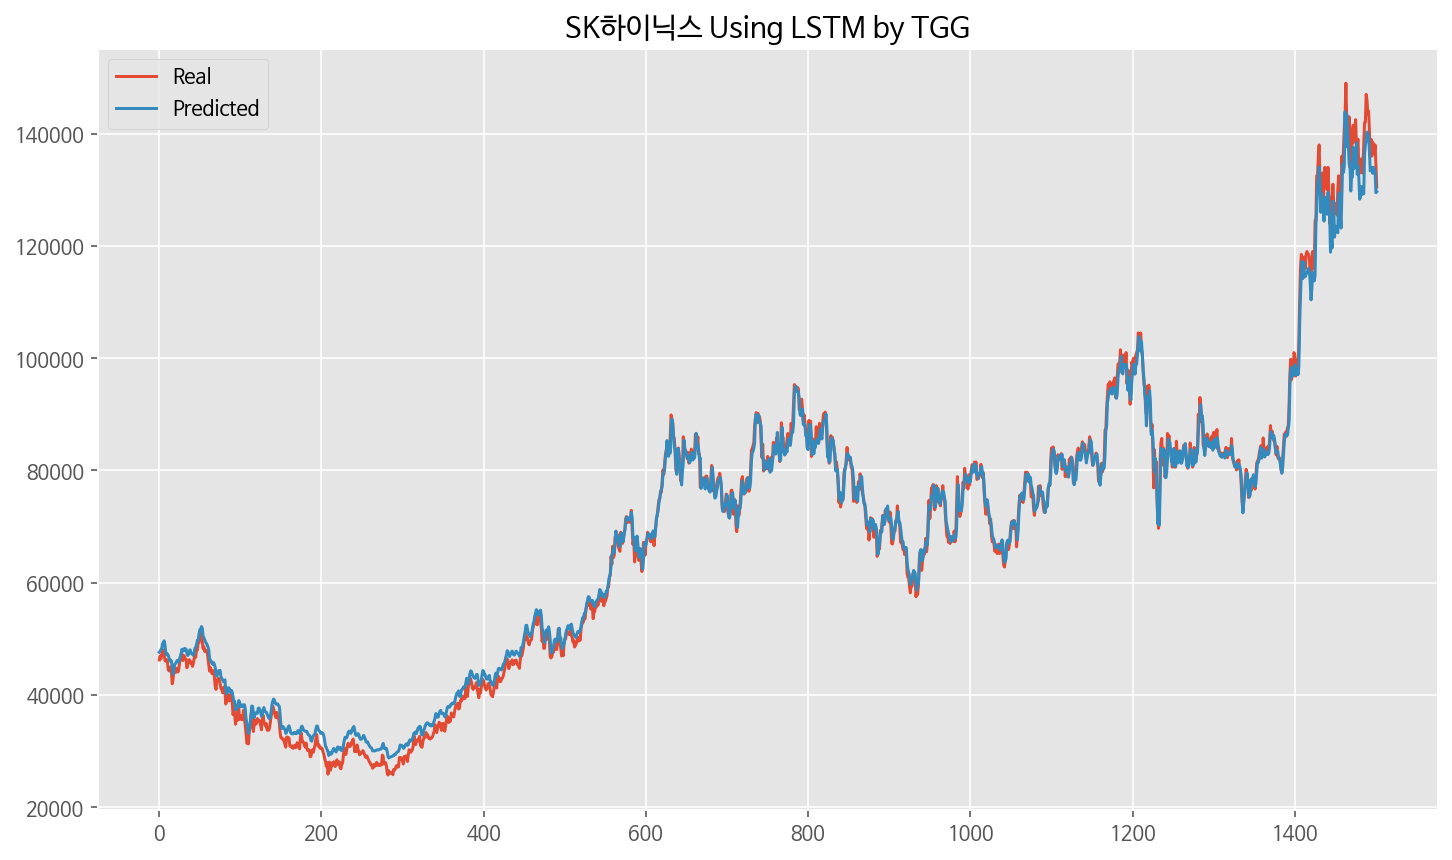

In [37]:
plt.gcf().set_size_inches(12, 7, forward=True)

start = 0
end = -1

# real = plt.plot(unscaled_y_test[start:end], label='real') 
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.title('SK하이닉스 Using LSTM by TGG')
plt.show();

In [38]:
col_name = ['real', 'pred']
real, pred = pd.DataFrame(unscaled_y[start:end]), pd.DataFrame(y_predicted[start:end])
foo = pd.concat([real, pred], axis = 1)
foo.columns = col_name

In [39]:
foo

,real,pred
0,46250,47617.710938
1,46950,47781.757812
2,46450,48118.824219
3,47100,48182.156250
4,47700,49106.945312
...,...,...
1497,138000,134023.250000
1498,136500,133678.250000
1499,138000,133295.468750
1500,134500,129489.304688


In [40]:
foo.corr()

,real,pred
real,1.000000,0.998859
pred,0.998859,1.000000


In [41]:
foo['real+1'] = foo['real'].shift(periods = 1)
foo[['real+1', 'pred']].corr()

,real+1,pred
real+1,1.000000,0.999291
pred,0.999291,1.000000


In [42]:
history_points = 50
ticker = '051910' # LG화학 

import keras
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers

np.random.seed(3)
# from tensorflow import set_random_seed
import tensorflow
print(tensorflow.__version__)
tensorflow.random.set_seed(33)
# from util import csv_to_dataset, history_points

# dataset

ohlcv_histories, _, next_day_open_values, unscaled_y, y_normaliser = call_dataset(ticker=ticker)

train_ratio = 0.7
n = int(ohlcv_histories.shape[0] * train_ratio)

ohlcv_train = ohlcv_histories[-n:-1]
y_train = next_day_open_values[-n:-1]

ohlcv_test = ohlcv_histories[:ohlcv_histories.shape[0]-n]
y_test = next_day_open_values[:ohlcv_histories.shape[0]-n]

unscaled_y_test = unscaled_y[:ohlcv_histories.shape[0]-n]

print('ohlcv_train.shape: ', ohlcv_train.shape)
print('ohlcv_test.shape: ',ohlcv_test.shape)

2.4.1
data:  (1553, 5)
data_normalized:  (1553, 5)
ohlcv_histories_normalized:  (1503, 50, 5)
ohlcv_histories_normalized.shape[0]:  1503
ohlcv_train.shape:  (1051, 50, 5)
ohlcv_test.shape:  (451, 50, 5)


In [43]:
# model architecture
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')
model.fit(x=ohlcv_train, y=y_train, batch_size=32, epochs=200, shuffle=True, validation_split=0.1)
# evaluation

y_test_predicted = model.predict(ohlcv_test)
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)
y_predicted = model.predict(ohlcv_histories)
y_predicted = y_normaliser.inverse_transform(y_predicted)

assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

from datetime import datetime
model.save(f'basic_model.h5')

Epoch 1/200
30/30 [==============================] - 2s 22ms/step - loss: 0.0768 - val_loss: 0.0904
Epoch 2/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0900
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0067
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0150
Epoch 5/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0070
Epoch 6/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0011 - val_loss: 0.0137
Epoch 7/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0078
Epoch 8/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0067
Epoch 9/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 0.0110
Epoch 10/200
30/30 [==============================] - 0s 6ms/step - loss: 8.7556e-04 - val_loss: 0.0068
Epoc

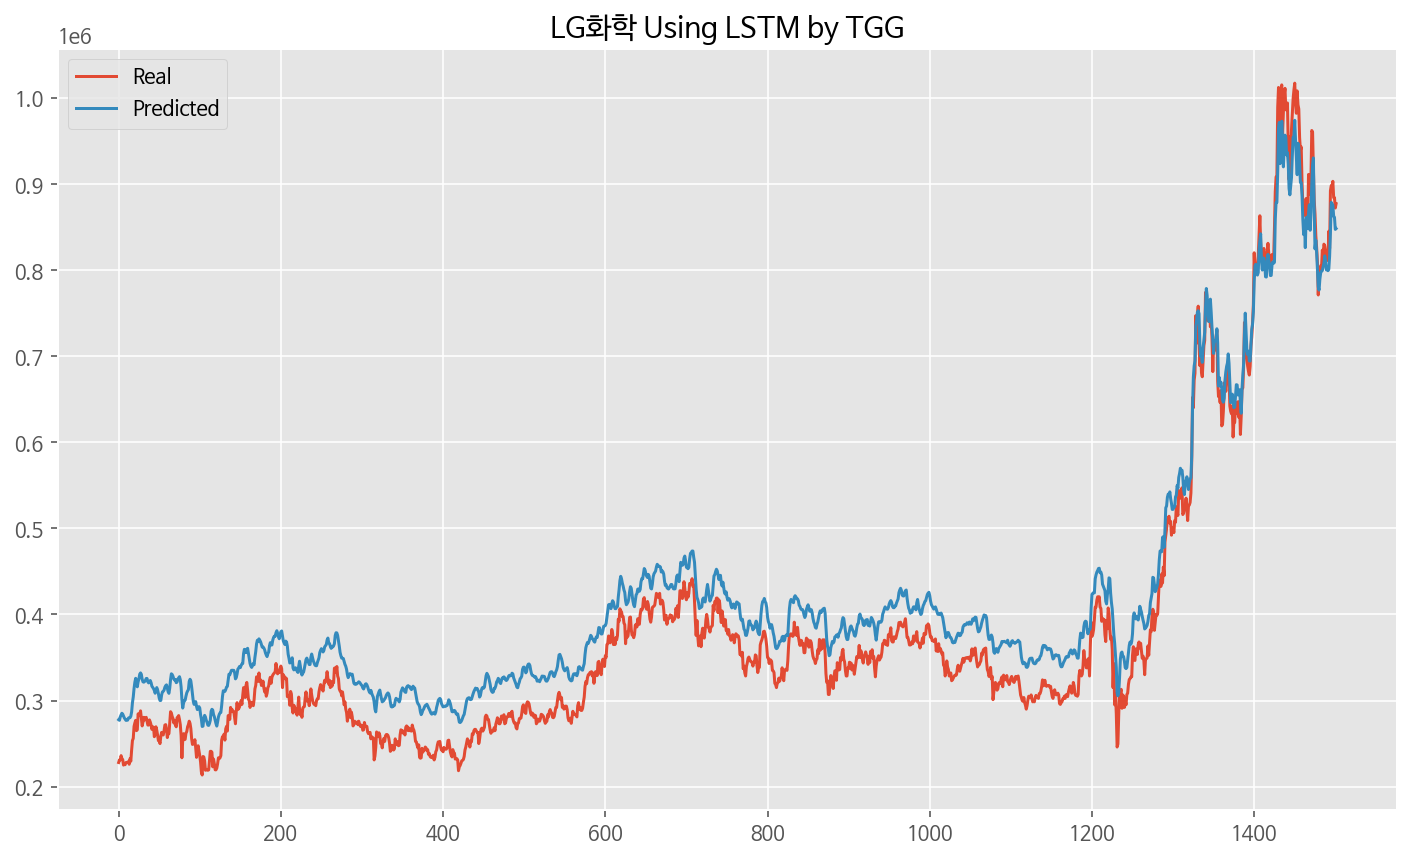

In [44]:
plt.gcf().set_size_inches(12, 7, forward=True)

start = 0
end = -1

# real = plt.plot(unscaled_y_test[start:end], label='real') 
# pred = plt.plot(y_test_predicted[start:end], label='predicted')

real = plt.plot(unscaled_y[start:end], label='real')
pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.title('LG화학 Using LSTM by TGG')
plt.show();

In [45]:
col_name = ['real', 'pred']
real, pred = pd.DataFrame(unscaled_y[start:end]), pd.DataFrame(y_predicted[start:end])
foo = pd.concat([real, pred], axis = 1)
foo.columns = col_name

In [46]:
foo

,real,pred
0,228000,277726.03125
1,231000,277006.50000
2,231000,281008.62500
3,236000,283271.21875
4,232500,285191.28125
...,...,...
1497,903000,875356.12500
1498,884000,862247.12500
1499,884000,861248.50000
1500,872000,847151.06250


In [47]:
foo.corr()

,real,pred
real,1.000000,0.998721
pred,0.998721,1.000000


In [48]:
foo['real+1'] = foo['real'].shift(periods = 1)
foo[['real+1', 'pred']].corr()

,real+1,pred
real+1,1.000000,0.998935
pred,0.998935,1.000000


In [49]:
!pip freeze > requirements.txt